# Kernel Density Estimation

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
#from simple_colors import *
from copy import deepcopy
import sympy as sy
import sympy.stats

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

In [2]:
t, u, v, w, x, y, z  = sy.symbols('t u v w x y z',real =  True)
f = sy.Function('f')
def f(x):
    if x == 0:
        return 0
    else:
        return x + 1

In [3]:
y = np.array(range(3))
z = y.reshape(3,1)
print('y =',y)
z + y


y = [0 1 2]


array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

In [4]:
y = sy.symbols('y')
sy.pprint(y+sy.pi)
f(y)

y + π


y + 1

## Isotropic Kernels

In [8]:
h = sy.symbols('h',positive = True)
r = sy.symbols('r',positive = True, integer = True)
t, u, v, w, x, y, z  = sy.symbols('t u v w x y z',real = True)

### Hermite functions

#### Constructing a density kernel whose integral is one and whose integral against low order polynomials vanishes

Define a kernel in terms of Hermite polynomials so that integrates to one and integrates to zero for higher order polynomials

In [47]:
def sy_hermite_kernel(y = sympy.symbols('y'), band_width = sympy.symbols('h'), r = 1):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    wt = sy.exp(-y*y/2) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ... y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
#    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width)
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [50]:
fred = sy_hermite_kernel()
print(fred)

sqrt(2)*exp(-y**2/(2*h**2))/(2*sqrt(pi)*h)


#### Look at this kernel for different values of the order and the bandwidth
A smaller bandwidth makes a peakier kernel

A higher order means that there is potentially higher accuracy, although it may mean that the KDE has negative values

In [42]:
h = sy.symbols('h', positive = True)
y = sy.symbols('y', reals = True)
rarray = sy.Matrix([sy.Integer(1), sy.Integer(2), sy.Integer(3)])
nr = rarray.shape[0]

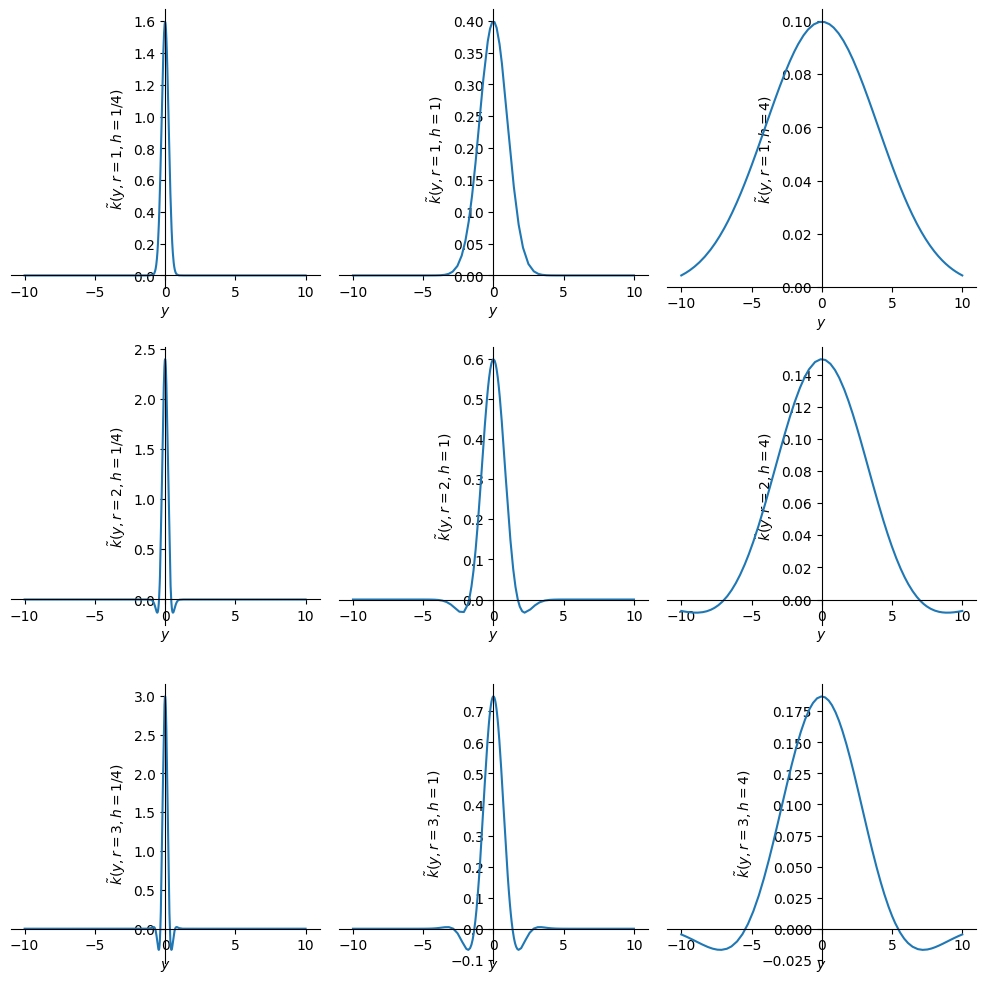

In [43]:
harray = sy.Matrix([sy.Rational(1/4), sy.Rational(1), sy.Rational(4)])
nh = harray.shape[0]
p = [];
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy_hermite_kernel(y,h,rval)
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(ktilde_sy.subs(h,hval),ylabel = r'$\tilde k(y,r='+str(rval)+',h='+str(hval)+')$', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));

#### Smoothing a density with respect to these kernels

In [40]:
r = 2
trial_density_sy = sy.stats.density(sy.stats.Normal(x,0,1))(y)
print(trial_density_sy)
ktilde_sy = sy_hermite_kernel(y,h,r)
integ = sy.integrate(ktilde_sy,(y,-sy.oo,sy.oo))
print(integ)
smoothed_density_sy = sy.integrate(trial_density_sy.subs(y,y-z)*ktilde_sy.subs(y,z),(z,-sy.oo,sy.oo))
print(smoothed_density_sy)

sqrt(2)*exp(-y**2/2)/(2*sqrt(pi))
1
-3*(-pi*h*y*exp(h**2*y**2/(4*(h**2/2 + 1/2)))*erf(h*y/(2*sqrt(h**2/2 + 1/2)))/(2*sqrt(h**2/2 + 1/2)) - pi*h*y*exp(h**2*y**2/(4*(h**2/2 + 1/2)))/(2*sqrt(h**2/2 + 1/2)))*exp(-y**2/2)/(4*pi**(3/2)*h*y) + 3*(-pi*h*y*exp(h**2*y**2/(4*(h**2/2 + 1/2)))*erf(h*y/(2*sqrt(h**2/2 + 1/2)))/(2*sqrt(h**2/2 + 1/2)) + pi*h*y*exp(h**2*y**2/(4*(h**2/2 + 1/2)))/(2*sqrt(h**2/2 + 1/2)))*exp(-y**2/2)/(4*pi**(3/2)*h*y) + (sqrt(pi)*h**4*y**4*(-1/16 - sqrt(pi)*sqrt(h**2/2 + 1/2)*(h**2*y**2/(8*(h**2/2 + 1/2)) + 1/4)*exp(h**2*y**2/(4*(h**2/2 + 1/2)))*erf(h*y/(2*sqrt(h**2/2 + 1/2)))/(4*h*y))/(h**2/2 + 1/2)**2 - pi*h**3*y**3*(h**2*y**2/(16*(h**2/2 + 1/2)) + 1/8)*exp(h**2*y**2/(4*(h**2/2 + 1/2)))/(2*(h**2/2 + 1/2)**(3/2)))*exp(-y**2/2)/(pi**(3/2)*h**3*y**3) - (sqrt(pi)*h**4*y**4*(-1/16 - sqrt(pi)*sqrt(h**2/2 + 1/2)*(h**2*y**2/(8*(h**2/2 + 1/2)) + 1/4)*exp(h**2*y**2/(4*(h**2/2 + 1/2)))*erf(h*y/(2*sqrt(h**2/2 + 1/2)))/(4*h*y))/(h**2/2 + 1/2)**2 + pi*h**3*y**3*(h**2*y**2/(16*(h**2/2 

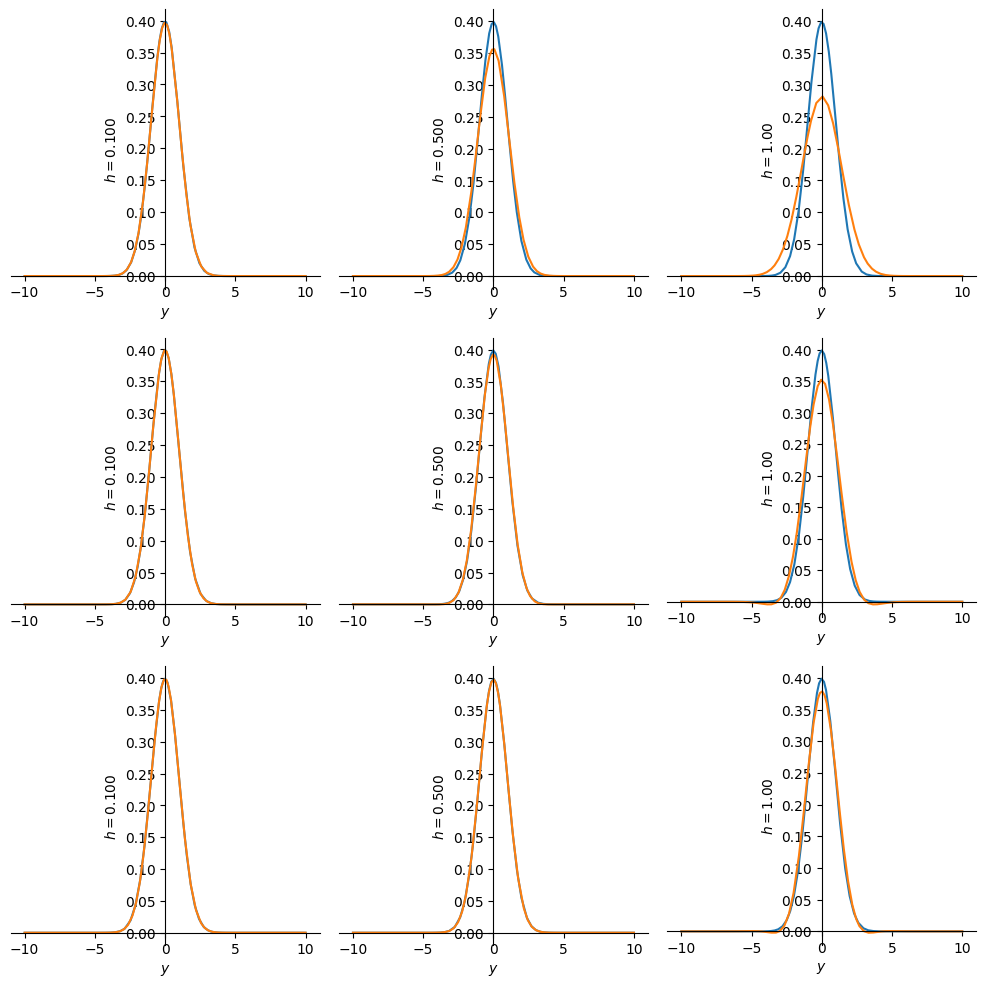

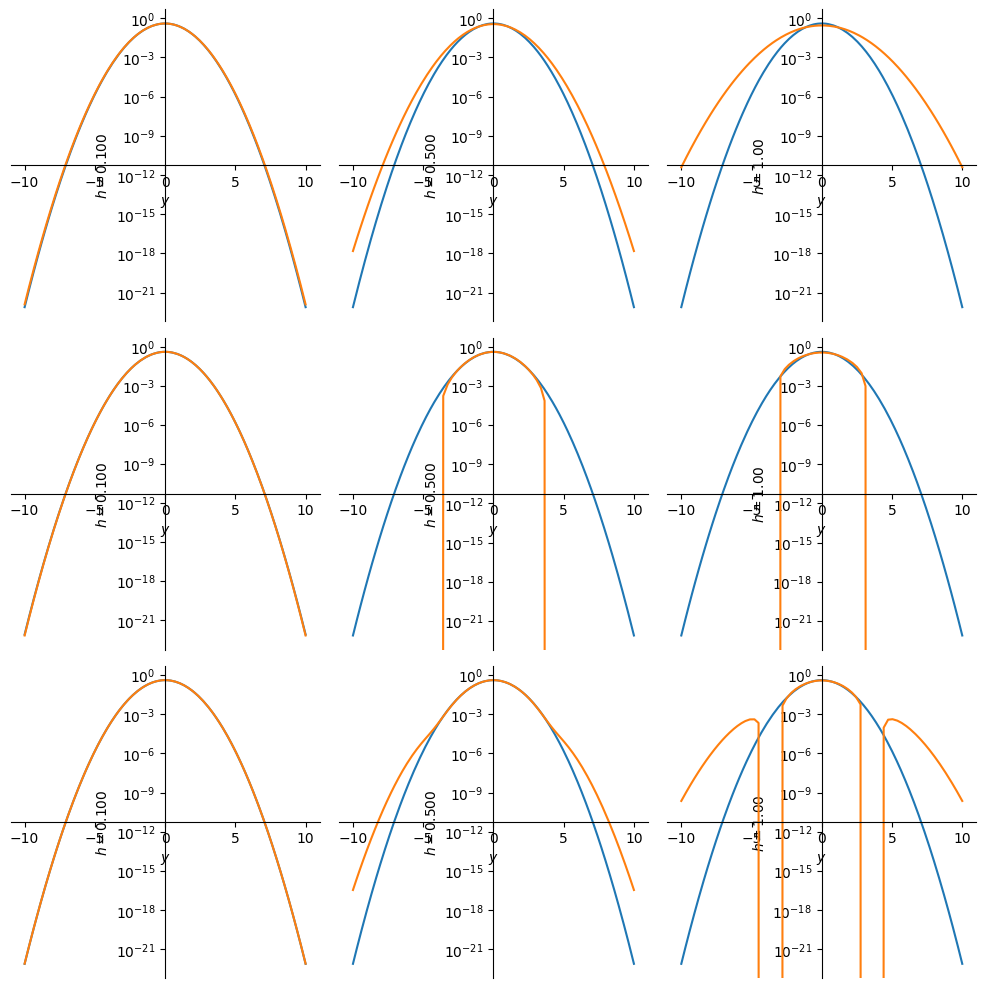

In [46]:
harray = sy.Matrix([sy.Rational(1/10), sy.Rational(1/2), sy.Rational(1)])
nh = harray.shape[0]
p = []
plog = []
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy_hermite_kernel(y,h,rval)
    smoothed_density_sy = sy.integrate(trial_density_sy.subs(y,y-z)*ktilde_sy.subs(y,z),(z,-sy.oo,sy.oo))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(trial_density_sy,smoothed_density_sy.subs(h,hval),ylabel = r'$h='+str(sy.N(hval,3))+'$', show = False))
        plog.append(sy.plot(trial_density_sy,smoothed_density_sy.subs(h,hval),ylabel = r'$h='+str(sy.N(hval,3))+'$', yscale = 'log', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));
sy.plotting.PlotGrid(nr,nh, *plog, size = (10,10));

In [26]:
ktilde_sy = sy_hermite_kernel(y,h,1)
ktilde_n = sy.lambdify((y,h),ktilde_sy)
print('ktilde(0,1) =',ktilde_sy.subs([(y,0),(h,1)]),'=',sy.N(ktilde_sy.subs([(y,0),(h,1)])),'=',ktilde_n(0,1))
yval = np.linspace(-3,3,7)
print('yval =',yval)
print(yval.shape)
ktilde_n(yval.reshape(7,1)-yval,1)

ktilde(0,1) = sqrt(2)/(2*sqrt(pi)) = 0.398942280401433 = 0.39894228040143276
yval = [-3. -2. -1.  0.  1.  2.  3.]
(7,)


array([[3.98942280e-01, 2.41970725e-01, 5.39909665e-02, 4.43184841e-03,
        1.33830226e-04, 1.48671951e-06, 6.07588285e-09],
       [2.41970725e-01, 3.98942280e-01, 2.41970725e-01, 5.39909665e-02,
        4.43184841e-03, 1.33830226e-04, 1.48671951e-06],
       [5.39909665e-02, 2.41970725e-01, 3.98942280e-01, 2.41970725e-01,
        5.39909665e-02, 4.43184841e-03, 1.33830226e-04],
       [4.43184841e-03, 5.39909665e-02, 2.41970725e-01, 3.98942280e-01,
        2.41970725e-01, 5.39909665e-02, 4.43184841e-03],
       [1.33830226e-04, 4.43184841e-03, 5.39909665e-02, 2.41970725e-01,
        3.98942280e-01, 2.41970725e-01, 5.39909665e-02],
       [1.48671951e-06, 1.33830226e-04, 4.43184841e-03, 5.39909665e-02,
        2.41970725e-01, 3.98942280e-01, 2.41970725e-01],
       [6.07588285e-09, 1.48671951e-06, 1.33830226e-04, 4.43184841e-03,
        5.39909665e-02, 2.41970725e-01, 3.98942280e-01]])

#### Computing the quality of merit of the density kernel

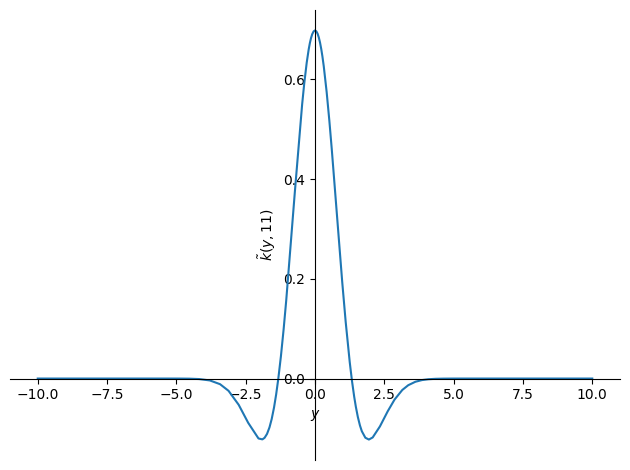

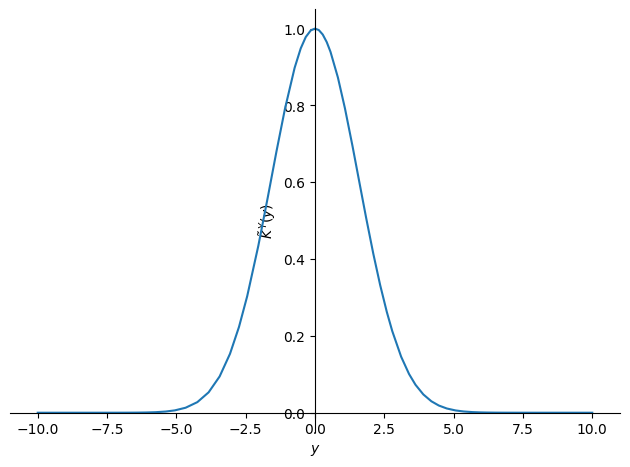

pi**(1/4)*(-sqrt(2)*h**4*z**2 + 7*sqrt(2)*h**4/4 + 5*sqrt(pi)*h**2 + 3*sqrt(2)*pi/2)*exp(z**2*(-1/2 + sqrt(pi)/(sqrt(2)*h**2 + 2*sqrt(pi))))/(sqrt(sqrt(2)*h**2 + 2*sqrt(pi))*(h**4 + 2*sqrt(2)*sqrt(pi)*h**2 + 2*pi))


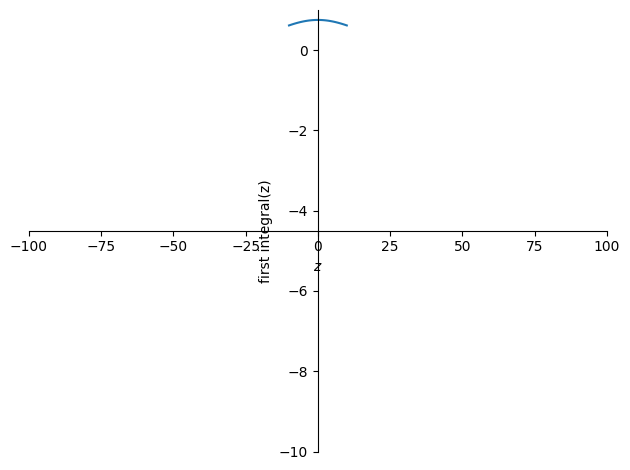

0.337053145879381


In [27]:
h = sy.symbols('h',positive = True)
ktilde = sy_hermite_kernel(y,h,2) #density kernel
hval = 1
sy.plot(ktilde.subs(h,hval),ylabel = r'$\tilde k(y,'+str(hval)+'1)$')
KYtilde = sy.exp(-y**2/2/(sy.sqrt(2*sy.pi))) #reproducing kernel
sy.plot(KYtilde,ylabel = r'$\tilde K^Y(y)$')
integone = sy.simplify(sy.integrate(ktilde.subs(h,1) * KYtilde.subs(y,(y-z)*h),(y,-sy.oo,sy.oo)))
print(integone)
sy.plot(integone.subs(h,1/10),ylabel = 'first integral(z)', xlim = [-100,100], ylim=[-10,1]);
print(sy.N(integone.subs([(h,1/10), (z,20)])))
#print(sy.N(integone))
#kqual = sy.simplify(KYtilde.subs(y,0) - 2*sy.integrate(ktilde * KYtilde.subs(y,y*h),(y,-sy.oo,sy.oo)) \
#    + sy.integrate(integone * ktilde.subs(y,z),(z,-sy.oo,sy.oo)))
#print(kqual)

In [292]:
print(sy.N(integone.subs([(h,1/10), (z,1000)])))

-2.12014388584230e-862


In [283]:
wt = sy.exp(-z*z/2)
#partial = sy.integrate((-sy.sqrt(2)*h**4*z**2 + 7*sy.sqrt(2)*h**4/4 + 5*sy.sqrt(sy.pi)*h**2 ) * wt,(z,-sy.oo,sy.oo))
partial = sy.integrate((sy.exp(z**2*(-1/2 + sy.sqrt(sy.pi)/(sy.sqrt(2)*h**2 + 2*sy.sqrt(sy.pi))))) * wt,(z,-sy.oo,sy.oo))
print(partial)

TypeError: 'xlim' is an invalid keyword argument for print()

In [ ]:
sy.plot(kqual, (h,0.01,10), xscale = 'log', yscale = 'log', ylabel = 'Smoothing Quality', axis_center = (0.008,1e-9));

## Generate some $x$ points

In [5]:
d = 1
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

iid pts [[0.96977204]
 [0.92150004]
 [0.97579372]
 ...
 [0.42501678]
 [0.11245829]
 [0.91115832]]
sobol pts [[0.10664934]
 [0.58567043]
 [0.4576133 ]
 ...
 [0.74166487]
 [0.36361538]
 [0.82700756]]


## Generate some $y=f(x)$ points

In [6]:
def testfun(x):
  # return np.exp(-5*x)*np.sin(2*np.pi*x)
    return sp.stats.norm.ppf(x)

In [7]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

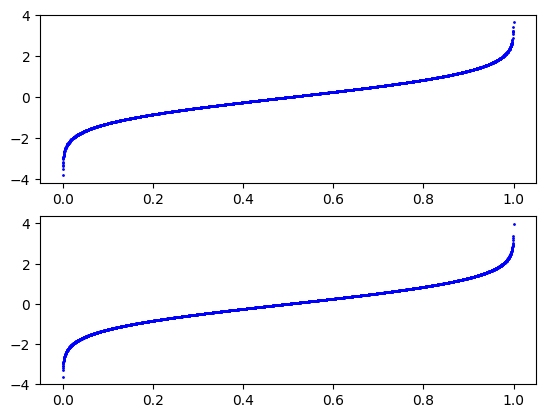

In [8]:
fig,ax = plt.subplots(2)
ax[0].plot(iidpts, yiid, 'b.', markersize = 2)
ax[1].plot(sobpts, ysob, 'b.', markersize = 2);

## Compute the kernel density estimator

In [51]:
def kde(y,x):
    density_estimate = stats.gaussian_kde(y.T)
    kdevalues = density_estimate(x)
    return kdevalues, density_estimate    
    #return density_estimate

In [52]:
right = 3
step = 0.01
xvalues = np.arange(-right,right,step)
small_n = int(np.sqrt(n))

In [55]:
kdeiidsmall, trash = kde(yiid[:small_n],xvalues)
print('small_n',small_n)
print('kdeiidsmall',kdeiidsmall[:10])
kdeiid, trash = kde(yiid,xvalues)
kdesobsmall, trash = kde(ysob[:small_n],xvalues)
kdesob, trash = kde(ysob,xvalues)

small_n 64
kdeiidsmall [0.00182468 0.00192969 0.00203995 0.00215567 0.00227707 0.00240438
 0.00253783 0.00267765 0.00282409 0.0029774 ]


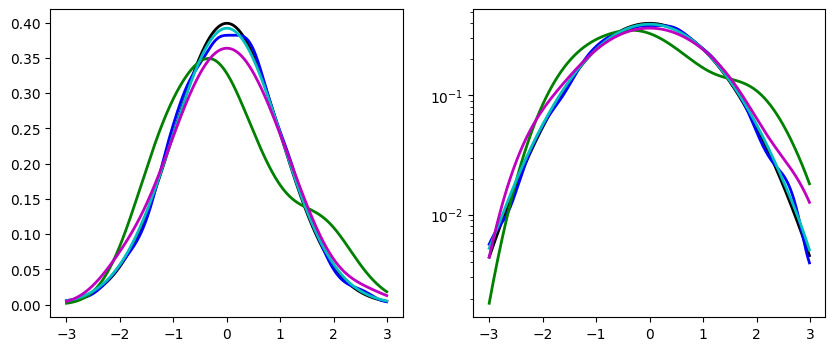

In [77]:
fig,ax = plt.subplots(1,ncols=2,figsize = (10,4))
for ii in range(2):
    ax[ii].plot(xvalues, stats.norm.pdf(xvalues), 'k-', linewidth = 2);
    ax[ii].plot(xvalues, kdeiid, 'b-', linewidth = 2)
    ax[ii].plot(xvalues, kdeiidsmall, 'g-', linewidth = 2)
    ax[ii].plot(xvalues, kdesob, 'c-', linewidth = 2)
    ax[ii].plot(xvalues, kdesobsmall, 'm-', linewidth = 2);
ax[1].set_yscale('log')